In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import datetime
from datetime import datetime
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
df = pd.read_csv("rts.csv",index_col = "RTSI$ Index",parse_dates=["RTSI$ Index"])

In [38]:
df = df.drop("Dates")
df = df.drop("Unnamed: 6",axis = 1)
df = df.rename_axis("Date")
df.head()

,Last Price,High Price,Low Price,Volume,Open Price,SPX Index,Last Price.1,High Price.1,Low Price.1,Volume.1,Open Price.1
Date,,,,,,,,,,,
10.01.2006,1190.34,1192.9,1128.2,45551788,1128.2,03.01.2006,1268.8,1270.22,1245.74,1511666432,1248.29
11.01.2006,1216.66,1216.92,1188.86,98596352,1190.04,04.01.2006,1273.46,1275.37,1267.74,1451294208,1268.8
12.01.2006,1255.92,1261.42,1216.96,127009136,1216.96,05.01.2006,1273.48,1276.91,1270.3,1419537536,1273.46
13.01.2006,1239.76,1261.57,1234.1,72828544,1255.65,06.01.2006,1285.45,1286.09,1273.48,1536703616,1273.48
16.01.2006,1276.9,1277.26,1240.05,57721104,1240.05,09.01.2006,1290.15,1290.78,1284.82,1317811584,1285.45


In [39]:
df["Date"] = df.index

In [40]:
df.dropna(inplace = True)

In [41]:
df[df.columns[:5]] = df[df.columns[:5]].astype("float")
df[df.columns[6:-1]] = df[df.columns[6:-1]].astype("float")

In [42]:
def todate(x):
    return datetime.strptime(x,'%d.%m.%Y')
df.index = df.index.map(todate)
df["SPX Index"] = df["SPX Index"].apply(todate)

In [43]:
df.index

DatetimeIndex(['2006-01-10', '2006-01-11', '2006-01-12', '2006-01-13',
               '2006-01-16', '2006-01-17', '2006-01-18', '2006-01-19',
               '2006-01-20', '2006-01-23',
               ...
               '2018-02-19', '2018-02-20', '2018-02-21', '2018-02-22',
               '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01',
               '2018-03-02', '2018-03-05'],
              dtype='datetime64[ns]', name='Date', length=3036, freq=None)

In [10]:
df.columns

Index(['Last Price', 'High Price', 'Low Price', 'Volume', 'Open Price',
       'SPX Index', 'Last Price.1', 'High Price.1', 'Low Price.1', 'Volume.1',
       'Open Price.1', 'Date'],
      dtype='object')

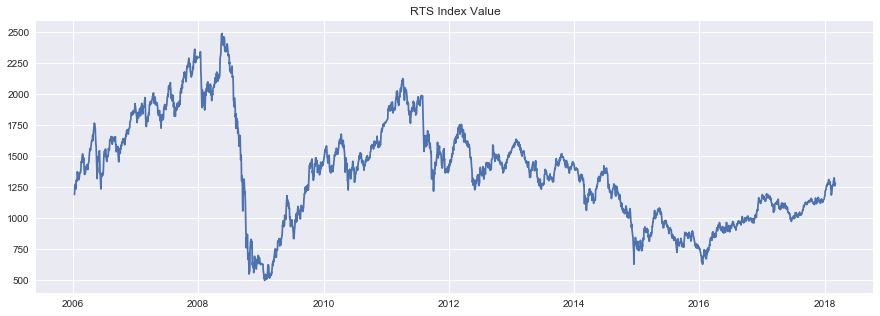

In [28]:
plt.figure(figsize=(15,5))
plt.plot(df.index,df["Last Price"])
plt.title("RTS Index Value")
plt.show()

In [15]:
print("Критерий Дики-Фуллера")#проверка на стационарность
result = sm.tsa.stattools.adfuller(df["Last Price"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Критерий Дики-Фуллера
ADF Statistic: -1.961476
p-value: 0.303716
Critical Values:
	5%: -2.862
	1%: -3.433
	10%: -2.567


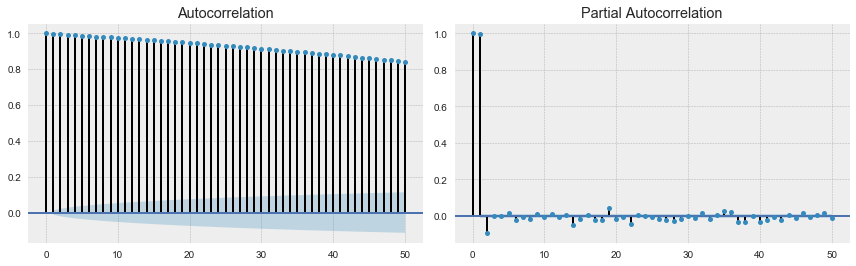

In [16]:
tsplot(df["Last Price"],lags = 50)

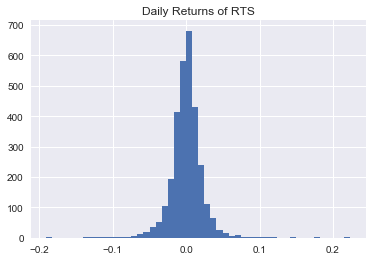

In [17]:
plt.hist(df["Last Price"].pct_change()[1:],bins=50)
plt.title("Daily Returns of RTS")
plt.show()

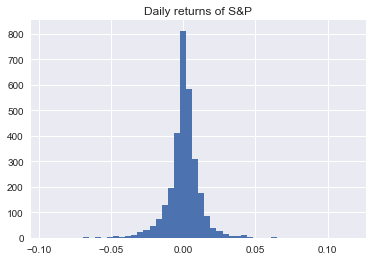

In [18]:
plt.hist(df["Last Price.1"].pct_change()[1:],bins=50)
plt.title("Daily returns of S&P")
plt.show()

### Tрендоследящая стратегия

Построим график средних значений для разных окон

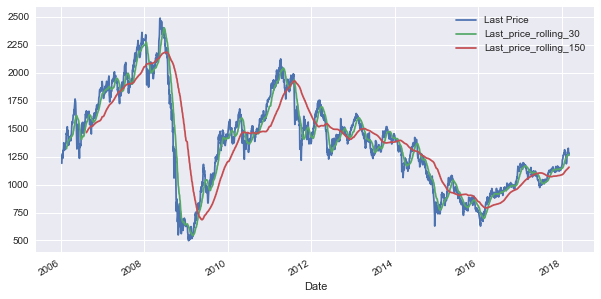

In [19]:
#для ртс
df["Last_price_rolling_30"] = df["Last Price"].rolling(window=30).mean()
df["Last_price_rolling_150"] = df["Last Price"].rolling(window=150).mean()
df[['Last Price', 'Last_price_rolling_30', 'Last_price_rolling_150']].plot(figsize = (10,5))
plt.show()

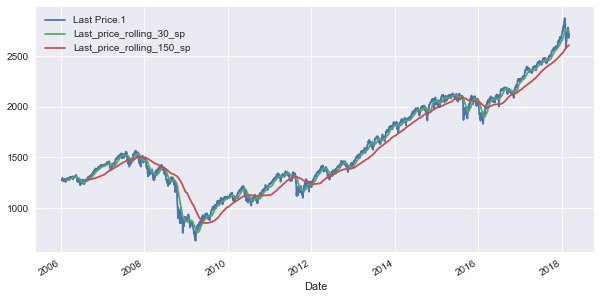

In [20]:
#для S&P
df["Last_price_rolling_30_sp"] = df["Last Price.1"].rolling(window=30).mean()

df["Last_price_rolling_150_sp"] = df["Last Price.1"].rolling(window=150).mean()

df[['Last Price.1', 'Last_price_rolling_30_sp', 'Last_price_rolling_150_sp']].plot(figsize = (10,5))
plt.show()

Элементарная стратегия

In [21]:
def strategy(short, long, a):
    #находим точки когда покупаем и продаем
    signs = pd.DataFrame(index=a.index)
    signs['signal'] = 0.0
    signs['short_mavg_rts'] = a.rolling(window=short, min_periods=1).mean()
    signs['long_mavg_rts'] = a.rolling(window=long, min_periods=1, center=False).mean()
    signs["signal"] = np.where(signs["short_mavg_rts"] - signs["long_mavg_rts"] >0, 1,0)#получаем тренд
    signs["trades"] = signs["signal"].diff()
    fig = plt.figure()
    ax1 = fig.add_subplot(212,ylabel='Price in $')
    ax1.plot(a, color='g')
    ax1.plot(signs["short_mavg_rts"])
    ax1.plot(signs["long_mavg_rts"])
    signs[['short_mavg_rts', 'long_mavg_rts']].plot(ax=ax1,figsize = (11,7))
    ax1.plot(signs.loc[signs.trades == 1.0].index, signs.short_mavg_rts[signs.trades == 1.0],'*', markersize=10,
             color='y')
    ax1.plot(signs.loc[signs.trades == -1.0].index, signs.short_mavg_rts[signs.trades == -1.0],'^', markersize=10,
             color='black')    
    plt.show()
    
    print("Было сделано %s сделок покупки и продажи"%signs.trades.value_counts()[1])
    #находим стоимость портфеля за рассматриваемый период
    money = 100000
    trades = pd.DataFrame(index=signs.index).fillna(0.0)
    trades['RTS'] = 100*signs['signal']#покупаем 100 штук в каждой сделке, можем занимать деньги, соответственно обратно тоже продаем 100 штук
    port = trades.multiply(a,axis = 0)
    pos_diff = trades.diff()
    port['holdings'] = (trades.multiply(a,axis = 0)).sum(axis=1)
    port['cash'] = money - (pos_diff.multiply(a,axis =0)).sum(axis=1).cumsum()   
    port['total'] = port['cash'] + port['holdings']
    fig2 = plt.figure()#стоимость портфеля
    ax2 = fig2.add_subplot(212, ylabel='Portfolio value in $')
    port['total'].plot(ax=ax2, figsize = (10,5))
    plt.show()

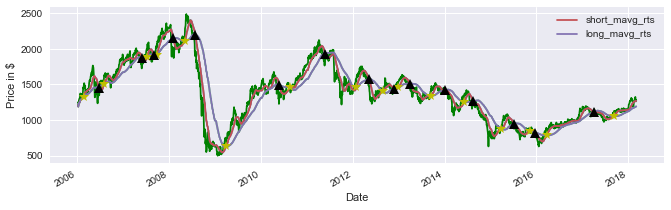

Было сделано 16 сделок покупки и продажи


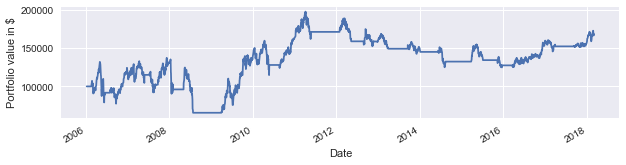

In [22]:
strategy(30,100,df["Last Price"])

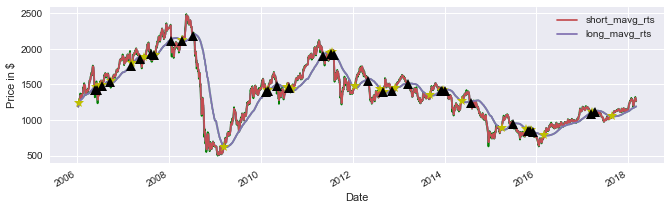

Было сделано 33 сделок покупки и продажи


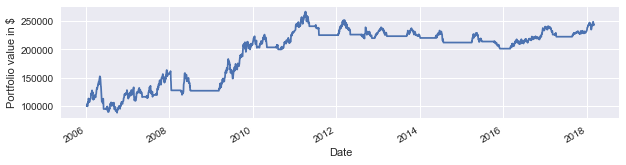

In [23]:
strategy(3,100,df["Last Price"])

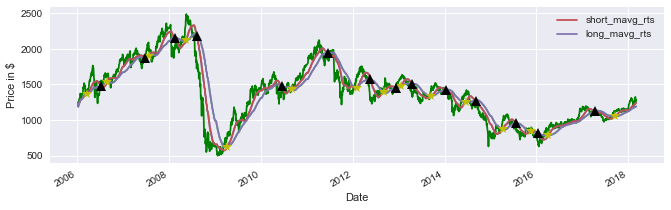

Было сделано 15 сделок покупки и продажи


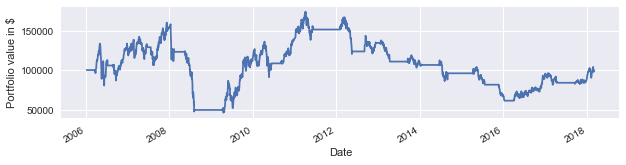

In [24]:
strategy(50,100,df["Last Price"])

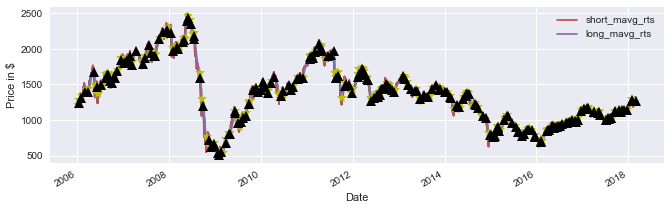

Было сделано 232 сделок покупки и продажи


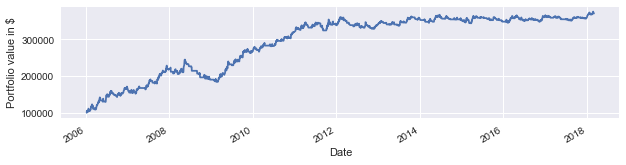

In [25]:
strategy(1,10,df["Last Price"])